# Zillow Real Estate Time Series Analysis

Author: Kyunghwan William Kim

Track: Data Science Flex

## Time Series Model for Real Estate Investment Company

This project assumes to be an investment firm based in Long Island New York to provide detailed analysis and insights to investors who are interested in real estate for financial growth. Our target clients are mid-income families or individuals with initial budget under $1,000,000 and are looking to buy in 2023.

The scope of this project will be to conduct a time series analysis to predict the 5 best zipcodes to invest in based on ROI.

What we’ll be doing in this project is analyzing these features of a time series data set, and then seeing if we can use mathematical models to forecast into the future. We’ll also see how we can split our original time series data set to evaluate how well our model predicts the future.

## Our Data

This project will explore the Housing Prices in the United States, from the years 1996 - 2018, with our frequency being Monthly Production output.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:
* RegionID: Unique index
* RegionName: Unique Zip Code
* City: City related to Zip Code
* State: State related to Zip Code
* Metro: Metropolitan Area related to Zip Code
* CountyName: County related to Zip Code
* SizeRank: Numerical rank of size of Zip Code
* 1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018

## Success Metrics

* ROI (Return on Investment from Initial to Final House Price.
* For evaluating the model, we will use he AIC (Akaike Information Criterion) as the regularization measure. The AIC is an estimator of the relative quality of statistical models for a given set of data.
* We shall check for the accuracy of our forecasts using MSE (Mean Squared Error). This will provide us with the average error of our forecasts. 

# Load the Data/Filtering for Chosen Zipcodes

## Import Libraries and Load the Data 


In [1]:
# Analysis libraries
import pandas as pd
import numpy as np
import itertools

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import time

# Warning libraries
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

# Metric libraries
from sklearn.metrics import mean_squared_error

# Modeling libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from collections import Counter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.linear_model import LassoLarsCV

In [2]:
# Read in the data file
df = pd.read_csv('zillow_data.csv')

# Examine the shape of the dataset
print(df.shape)

# Examine the first five rows
df.head()

(14723, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Filtering by New York State and Nassau County

In [3]:
# Create a new dataset that focuses on the New York Metro
nydf=df[(df['State']=='NY')]

In [4]:
# Create new dataset to focus on Nassau County
lidf = nydf[(nydf['CountyName']=='Nassau')]

lidf.shape

(63, 272)

Our filtered data now consists of 63 rows which represent unique zipcodes and 272 columns. Of those 272 columns, 7 columns represent features that describe the various zipcodes. The remaining columns represent a time series that span from April 1996 to April 2018. The values are the median home prices for that zipcode on that specific month. 

# EDA & Data Cleaning

In [5]:
# Starting analysis of first variable, RegionID
print(lidf.RegionID.value_counts())
print(lidf.RegionID.nunique())
print(lidf.RegionID.min())
print(lidf.RegionID.max())

62234    1
62152    1
62164    1
62229    1
62165    1
        ..
62196    1
61981    1
62145    1
62236    1
62159    1
Name: RegionID, Length: 63, dtype: int64
63
61976
62274


In [6]:
# Seems like Region ID is just a unique ID number, let's convert to strings.
lidf.RegionID = lidf.RegionID.astype('string')

In [7]:
# Starting analysis of second variable, RegionName
print(lidf.RegionName.value_counts())
print(lidf.RegionName.nunique())

11758    1
11559    1
11576    1
11753    1
11577    1
        ..
11714    1
11010    1
11552    1
11762    1
11569    1
Name: RegionName, Length: 63, dtype: int64
63


In [8]:
# Region Name is the zipcode, let's convert to strings.
lidf.RegionName = lidf.RegionName.astype('string')

In [9]:
# Rename RegionName to Zipcode
lidf = lidf.rename(columns={'RegionName': 'Zipcode'})
lidf.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1010,62234,11758,Massapequa,NY,New York,Nassau,1011,183700.0,184000.0,184300.0,...,464200,466400,468000,470400,472400,474600,476600,479300,482900,485900
1467,62154,11561,Long Beach,NY,New York,Nassau,1468,177100.0,177100.0,177200.0,...,532200,535200,536600,538100,538400,538100,537000,541400,554600,566900
1597,62143,11550,Hempstead,NY,New York,Nassau,1598,133600.0,133900.0,134200.0,...,316900,320400,323200,325800,327100,327800,328200,329800,334400,339100
2277,62133,11520,Freeport,NY,New York,Nassau,2278,144700.0,144600.0,144500.0,...,346700,350100,351500,353000,354800,356900,358700,360700,363900,366700
2279,62170,11590,Westbury,NY,New York,Nassau,2280,161600.0,161800.0,161900.0,...,441400,442900,444900,447700,449700,451500,453300,456100,461400,466200


In [10]:
# Exploring the format of the zip codes
print(lidf.Zipcode.min())
print(lidf.Zipcode.max())

11001
11804


In [11]:
# Analysis of variable labeled 'City'
lidf.City.value_counts()

Great Neck             4
Valley Stream          2
Massapequa             1
Hewlett                1
Roslyn                 1
Jericho                1
Roslyn Heights         1
Woodmere               1
Roosevelt              1
Glen Head              1
East Rockaway          1
Oyster Bay             1
Williston Park         1
Woodbury               1
Malverne               1
Lawrence               1
Manhasset              1
Island Park            1
Cedarhurst             1
Bayville               1
Locust Valley          1
Albertson              1
Inwood                 1
Sea Cliff              1
Old Bethpage           1
Carle Place            1
East Norwich           1
Atlantic Beach         1
Old Westbury           1
Uniondale              1
Massapequa Park        1
Seaford                1
Long Beach             1
Hempstead              1
Freeport               1
Westbury               1
North New Hyde Park    1
Levittown              1
East Meadow            1
Hicksville             1


In [12]:
# Starting analysis of last variable, SizeRank
print(lidf.SizeRank.value_counts())
print(lidf.SizeRank.nunique())
print(lidf.SizeRank.min())
print(lidf.SizeRank.max())

1011     1
9668     1
8079     1
8259     1
8266     1
        ..
5669     1
5885     1
5904     1
5915     1
13473    1
Name: SizeRank, Length: 63, dtype: int64
63
1011
13473


SizeRank is just a ranking order based on zipcode Size

## Success Metrics

To solve the problems raised under business understanding, two columns will be created.

* Return on Investment (ROI) 

ROI is the measure of expected returns from investments
    
* Coefficient of Variation (CV)

CV is a measure of the dispersion of data points around the mean and represents the ratio of the standard deviation to the mean. It allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.

In [13]:
# Return on Investment
lidf['ROI'] = (lidf['2018-04']/ lidf['1996-04'])-1

In [14]:
# Return on Investment after 2008 Housing Crash
lidf['ROI2'] = (lidf['2018-04']/ lidf['2012-01'])-1

In [15]:
# Coefficient of Variation

# Calculating STD for CV
lidf['std'] = lidf.loc[:, '1996-04':'2018-04'].std(skipna=True, axis=1)

# Calculating Mean for CV
lidf['mean'] = lidf.loc[:, '1996-04':'2018-04'].mean(skipna=True, axis=1)

# Calculating CV
lidf['CV'] = lidf['std']/lidf['mean']

# Dropping std and mean
lidf.drop(['std', 'mean'], inplace=True, axis=1)

In [16]:
lidf[['Zipcode', 'ROI', 'CV']].head()

,Zipcode,ROI,CV
1010,11758,1.645073,0.256651
1467,11561,2.201016,0.300683
1597,11550,1.538174,0.296091
2277,11520,1.534209,0.287206
2279,11590,1.884901,0.287230


## Check for NaN (null) values

In [17]:
# Checking our dataframe for NaN values
print(f'There are {lidf.isna().sum().sum()} NaNs in our original dataframe')

# Backfilling that single NaN
lidf.fillna(method='bfill', inplace=True)

# Sanity check
print(f'There are {lidf.isna().sum().sum()} NaNs after using backfill')

There are 0 NaNs in our original dataframe
There are 0 NaNs after using backfill


## Filter for Client's Budget

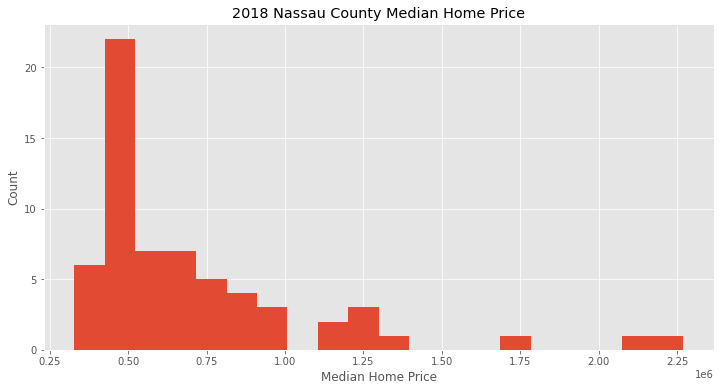

In [18]:
# Getting a list of the values for the last date in our time series
recent_median_home_prices = list(lidf['2018-04'])

# Plotting the results
fig, ax = plt.subplots(figsize=(12,6))
plt.hist(recent_median_home_prices, bins=20)
plt.title('2018 Nassau County Median Home Price')
plt.xlabel('Median Home Price')
plt.ylabel('Count')
plt.show()

In [19]:
# Filter for Client's budget
lidf_budget = lidf[lidf['2018-04']<=1000000]

# Review shape
lidf_budget.shape

(54, 275)

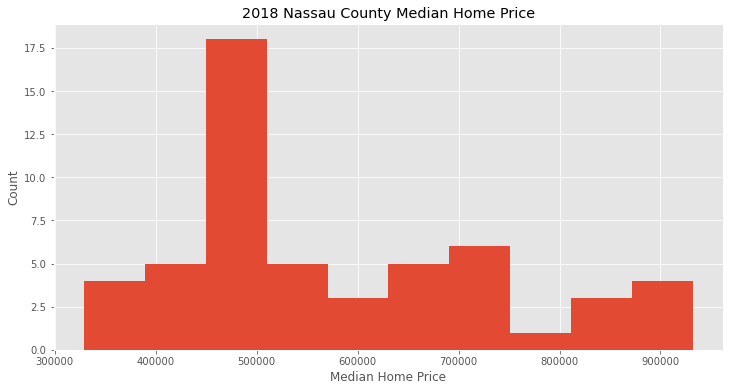

In [20]:
# Visualize with Client's budget
recent_median_home_prices = list(lidf_budget['2018-04'])

fig, ax = plt.subplots(figsize=(12,6))
plt.hist(recent_median_home_prices, bins=10)
plt.title('2018 Nassau County Median Home Price')
plt.xlabel('Median Home Price')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

We’ll need to do some quick processing to convert this data to have a time series index.

Right now our variables are actually just a list of strings that look like a date, we’ll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values.

## Reshape from Wide to Long Format

In [21]:
# Create a copy of the dataset to convert into long view 
lidf2 = lidf_budget.copy()

In [22]:
def melt_df(data):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(data, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 
                                    'CountyName', 'SizeRank', 'ROI', 'ROI2', 'CV'], var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [23]:
lidf2 = melt_df(lidf2)

In [24]:
# Converting the date data type into date time and indexing
lidf2['Date'] = pd.to_datetime(lidf2['Date'], format='%m/%y')

# Set the 'Date' column as index
lidf2.set_index('Date', inplace=True)

In [25]:
lidf2.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI,ROI2,CV,value
Date,,,,,,,,,,,
1996-04-01,62234,11758,Massapequa,NY,New York,Nassau,1011,1.645073,0.321817,0.256651,183700.0
1996-04-01,62154,11561,Long Beach,NY,New York,Nassau,1468,2.201016,0.288995,0.300683,177100.0
1996-04-01,62143,11550,Hempstead,NY,New York,Nassau,1598,1.538174,0.459750,0.296091,133600.0
1996-04-01,62133,11520,Freeport,NY,New York,Nassau,2278,1.534209,0.369305,0.287206,144700.0
1996-04-01,62170,11590,Westbury,NY,New York,Nassau,2280,1.884901,0.447826,0.287230,161600.0


In [26]:
# renaming the column value to median_price
lidf2.rename(columns = {'value' : 'MeanValue'}, inplace=True)

In [27]:
lidf2.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI,ROI2,CV,MeanValue
Date,,,,,,,,,,,
1996-04-01,62234,11758,Massapequa,NY,New York,Nassau,1011,1.645073,0.321817,0.256651,183700.0
1996-04-01,62154,11561,Long Beach,NY,New York,Nassau,1468,2.201016,0.288995,0.300683,177100.0
1996-04-01,62143,11550,Hempstead,NY,New York,Nassau,1598,1.538174,0.459750,0.296091,133600.0
1996-04-01,62133,11520,Freeport,NY,New York,Nassau,2278,1.534209,0.369305,0.287206,144700.0
1996-04-01,62170,11590,Westbury,NY,New York,Nassau,2280,1.884901,0.447826,0.287230,161600.0


In [28]:
# Drop unused features
lidf_clean = lidf_budget.drop(['RegionID','City','State','Metro','CountyName','SizeRank','ROI', 'ROI2','CV'], axis ='columns')

In [29]:
lidf_clean.head()

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1010,11758,183700.0,184000.0,184300.0,184600.0,185000.0,185300.0,185700.0,186100.0,186800.0,...,464200,466400,468000,470400,472400,474600,476600,479300,482900,485900
1467,11561,177100.0,177100.0,177200.0,177200.0,177300.0,177400.0,177500.0,177600.0,178000.0,...,532200,535200,536600,538100,538400,538100,537000,541400,554600,566900
1597,11550,133600.0,133900.0,134200.0,134500.0,134700.0,134900.0,135200.0,135400.0,135700.0,...,316900,320400,323200,325800,327100,327800,328200,329800,334400,339100
2277,11520,144700.0,144600.0,144500.0,144200.0,144000.0,143700.0,143500.0,143400.0,143500.0,...,346700,350100,351500,353000,354800,356900,358700,360700,363900,366700
2279,11590,161600.0,161800.0,161900.0,161900.0,161800.0,161800.0,161700.0,161500.0,161600.0,...,441400,442900,444900,447700,449700,451500,453300,456100,461400,466200


In [30]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='Date', value_name = 'MeanValue')
    melted['Date'] = pd.to_datetime(melted['Date'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [31]:
lidf_melt = melt_data(lidf_clean)

In [32]:
lidf_melt.head()

,Zipcode,Date,MeanValue
0,11758,1996-04-01,183700.0
1,11561,1996-04-01,177100.0
2,11550,1996-04-01,133600.0
3,11520,1996-04-01,144700.0
4,11590,1996-04-01,161600.0


In [33]:
lidf_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Zipcode    14310 non-null  string        
 1   Date       14310 non-null  datetime64[ns]
 2   MeanValue  14310 non-null  float64       
dtypes: datetime64[ns](1), float64(1), string(1)
memory usage: 335.5 KB


In [34]:
# Set Date as index
lidf_melt.set_index('Date', inplace = True)

In [35]:
lidf_melt.head()

,Zipcode,MeanValue
Date,,
1996-04-01,11758,183700.0
1996-04-01,11561,177100.0
1996-04-01,11550,133600.0
1996-04-01,11520,144700.0
1996-04-01,11590,161600.0


# Data Visualization

In [36]:
# Visualizing the Statistics of the Data Columns
visual_lidf = lidf2[['RegionID', 'SizeRank', 'ROI', 'ROI2','CV']]

In [37]:
visual_lidf.describe()

,SizeRank,ROI,ROI2,CV
count,14310.000000,14310.000000,14310.000000,14310.000000
mean,6466.111111,1.738053,0.375926,0.265709
std,3238.190134,0.171033,0.073249,0.017600
min,1011.000000,1.350318,0.222259,0.231046
25%,3733.000000,1.622246,0.326377,0.252844
50%,5894.500000,1.733676,0.375157,0.264747
75%,9314.000000,1.846793,0.432327,0.276147
max,13473.000000,2.201016,0.502626,0.309694


In [38]:
lidf2.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI,ROI2,CV,MeanValue
Date,,,,,,,,,,,
1996-04-01,62234,11758,Massapequa,NY,New York,Nassau,1011,1.645073,0.321817,0.256651,183700.0
1996-04-01,62154,11561,Long Beach,NY,New York,Nassau,1468,2.201016,0.288995,0.300683,177100.0
1996-04-01,62143,11550,Hempstead,NY,New York,Nassau,1598,1.538174,0.459750,0.296091,133600.0
1996-04-01,62133,11520,Freeport,NY,New York,Nassau,2278,1.534209,0.369305,0.287206,144700.0
1996-04-01,62170,11590,Westbury,NY,New York,Nassau,2280,1.884901,0.447826,0.287230,161600.0


## Cities with the Highest Median House Price

In [39]:
# Visualizing top five cities with highest house prices
topcities = pd.DataFrame(lidf2.groupby('City')['MeanValue'].mean()
                                    .sort_values(ascending=False).head(5))

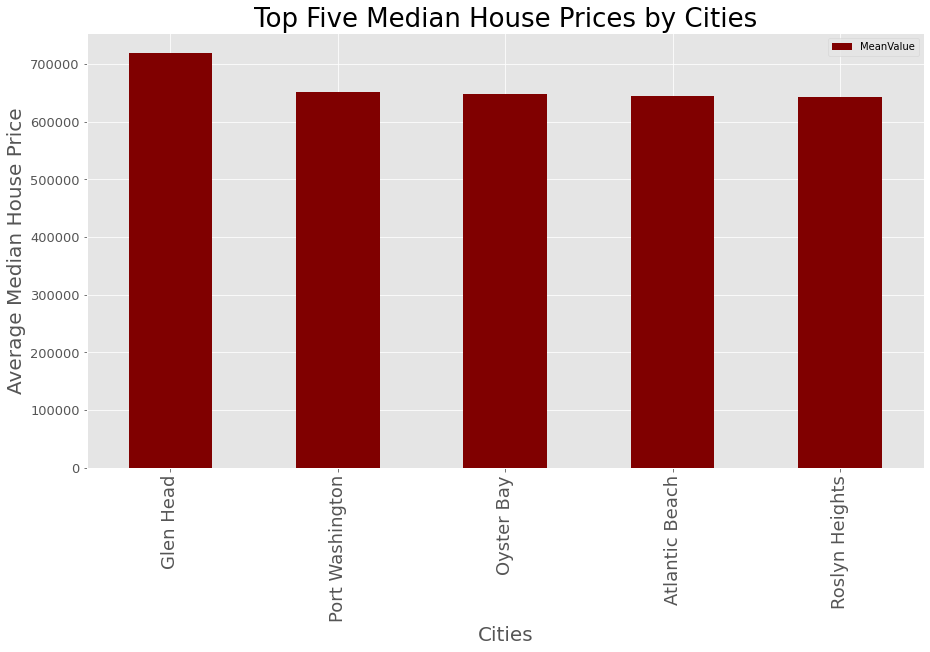

In [40]:
ax1 = topcities.plot(kind='bar', figsize=(15,8), color="maroon", fontsize=13);
ax1.set_alpha(0.8)

ax1.set_title("Top Five Median House Prices by Cities", fontsize=26)
ax1.set_ylabel("Average Median House Price", fontsize=20);
ax1.set_xlabel("Cities", fontsize=20)
plt.xticks(fontsize= 18)
plt.show()

## Zipcodes with Highest Price Volatility

In [41]:
# Visualizing top five zipcodes with highest price volatility
CV_topzip = pd.DataFrame(lidf2.groupby('Zipcode')['CV'].mean().sort_values(ascending=False).head(5))

Text(0.5, 0, 'Zipcodes')

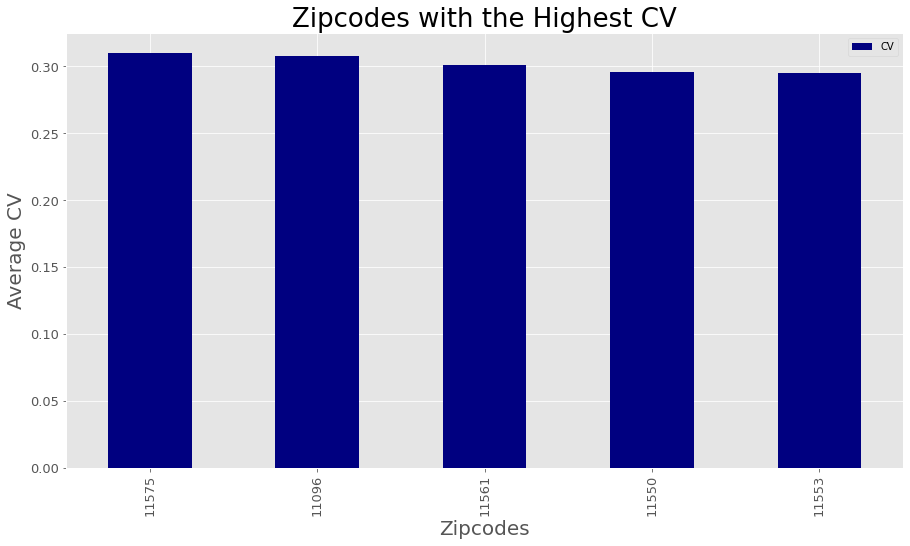

In [42]:
ax3 = CV_topzip.plot(kind='bar', figsize=(15,8), color='navy', fontsize=13);
ax3.set_alpha(0.8)

ax3.set_title("Zipcodes with the Highest CV", fontsize=26)
ax3.set_ylabel("Average CV", fontsize=20);
ax3.set_xlabel("Zipcodes", fontsize=20)

CV represents the coefficient of variation and how values deviate from the mean. Therefore, a high CV shows the price deviates further from the mean and means that there is presence of high price volatility. Areas with high price volatility may present the problem of being predicted effectively and hence can be an issue for investors looking to predict future median house sale prices.

Meaning that real estate investors should not invest in these areas

The zipcodes with the highest price volatility are:
* 11575: Roosevelt, NY
* 11096: Inwood, NY
* 11561: Long Beach, NY
* 11550: Hempstead, NY
* 11553: Uniondale, NY

## Zipcodes with Highest ROI

In [43]:
# Visualizing top five zipcodes with highest ROI
ROI_topzip = pd.DataFrame(lidf2.groupby('Zipcode')['ROI'].mean().sort_values(ascending=False).head(10))

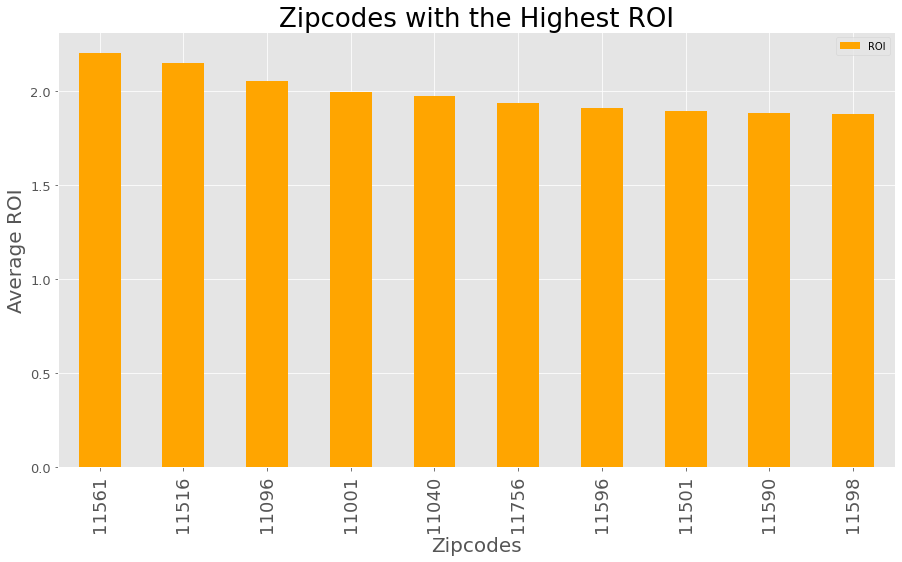

In [44]:
ax2 =ROI_topzip.plot(kind='bar', figsize=(15,8), color="orange", fontsize=13);
ax2.set_alpha(0.8)

ax2.set_title("Zipcodes with the Highest ROI", fontsize=26)
ax2.set_ylabel("Average ROI", fontsize=20);
ax2.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.show()

ROI is the calculation of the monetary value of an investment versus its cost. Which will be our key performance indicator.

Meaning that investors should invest in the zipcodes with the highest ROI's.

The zipcodes with the highest ROI's are:

* 11561: Long Beach, NY (X)
* 11516: Cedarhurst, NY
* 11096: Inwood, NY (X)
* 11001: Floral Park, NY
* 11040: New Hyde Park, NY
* 11756: Levittown, NY
* 11596: Williston Park, NY
* 11501: Mineola, NY
* 11590: Westbury, NY
* 11598: Woodmere, NY

## 2008 Housing Crisis

In [45]:
# The 'MS' string groups the data in buckets by start of the month
li_monthly = lidf_melt['MeanValue'].resample('MS').mean()

In [46]:
li_monthly

Date
1996-04-01    212922.222222
1996-05-01    213057.407407
1996-06-01    213159.259259
1996-07-01    213214.814815
1996-08-01    213253.703704
                  ...      
2017-12-01    562868.518519
2018-01-01    564492.592593
2018-02-01    567746.296296
2018-03-01    574570.370370
2018-04-01    581135.185185
Freq: MS, Name: MeanValue, Length: 265, dtype: float64

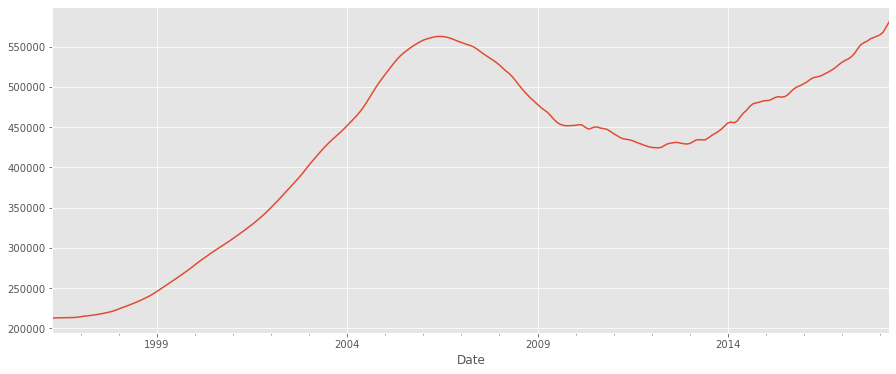

In [47]:
# Plot the time series
li_monthly.plot(figsize=(15,6))
plt.show()

The time series has spikes reflecting an obvious seasonality pattern, as well as an overall increasing trend.

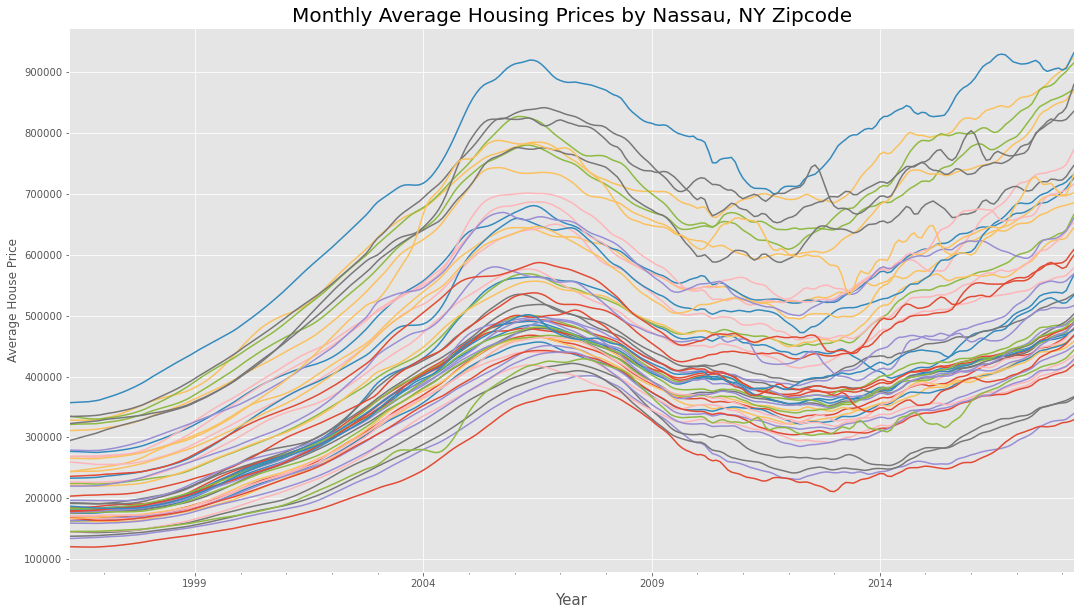

In [48]:
for zipcode in lidf_melt.Zipcode.unique():
    temp_df = lidf_melt[lidf_melt.Zipcode == zipcode]
    temp_df['MeanValue'].plot(figsize = (18,10), label=zipcode)

plt.xlabel("Year", fontsize = 15)
plt.ylabel("Average House Price")
plt.title('Monthly Average Housing Prices by Nassau, NY Zipcode', fontsize = 20);

Prices seem to have peaked before the 2008 recession, only to see a dramatic fall immediately after. Since then, prices have been steadily on the rise since 2012 but have yet to reach their pre-recession peaks.

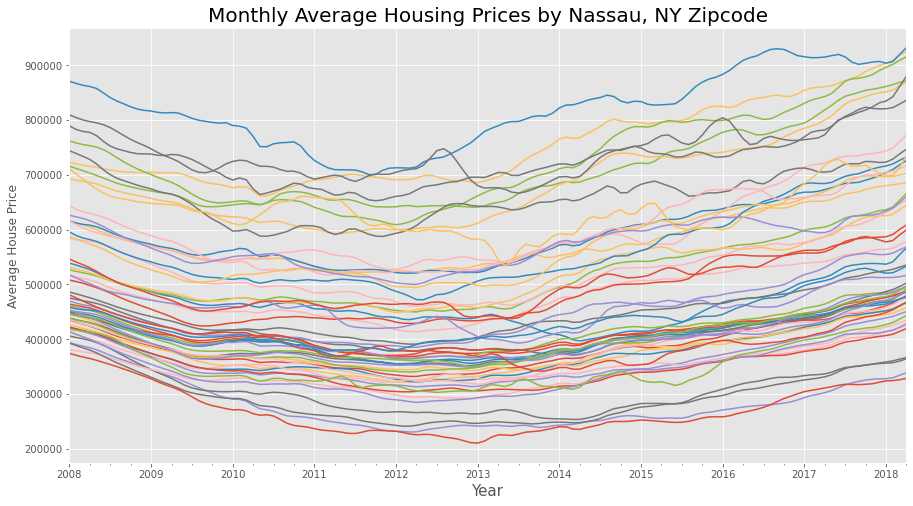

In [49]:
# focus on 2008 to 2018
for zipcode in lidf_melt.Zipcode.unique():
    temp_df = lidf_melt[lidf_melt.Zipcode == zipcode]
    temp_df['2008':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.xlabel("Year", fontsize = 15)
plt.ylabel("Average House Price")
plt.title('Monthly Average Housing Prices by Nassau, NY Zipcode', fontsize = 20);

##### To get more accurate prediction on 2020 and onwards data, we decided to use data 2012-Present.

In [50]:
df12 = lidf_melt['2012':]
df12_month = df12.groupby('Date')['MeanValue'].mean()

In [51]:
df12_month.head()

Date
2012-01-01    424720.370370
2012-02-01    424377.777778
2012-03-01    424229.629630
2012-04-01    424694.444444
2012-05-01    427064.814815
Name: MeanValue, dtype: float64

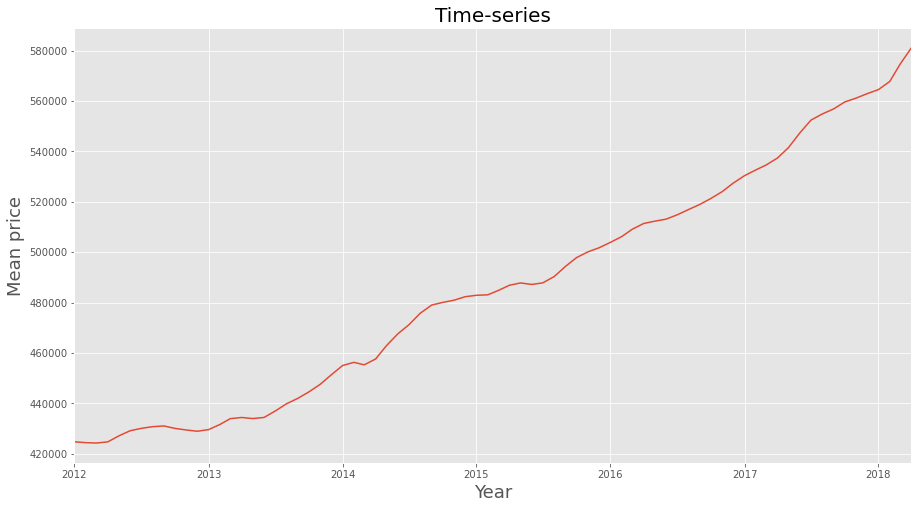

In [52]:
import datetime
import matplotlib.dates as dates
plt.figure(figsize=(15,8))
plt.plot(df12_month,label='Time-series')
plt.xlim(dates.date2num([df12_month.index[0], df12_month.index[-1]]))
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price", fontsize='18')
plt.title("Time-series", fontsize='20')
plt.show()

## Re-Examine Zipcodes with Highest ROI from 2012 to 2018.

In [53]:
# Visualizing top five zipcodes with highest ROI post 2012
ROI2_topzip = pd.DataFrame(lidf2.groupby('Zipcode')['ROI2'].mean().sort_values(ascending=False).head(7))

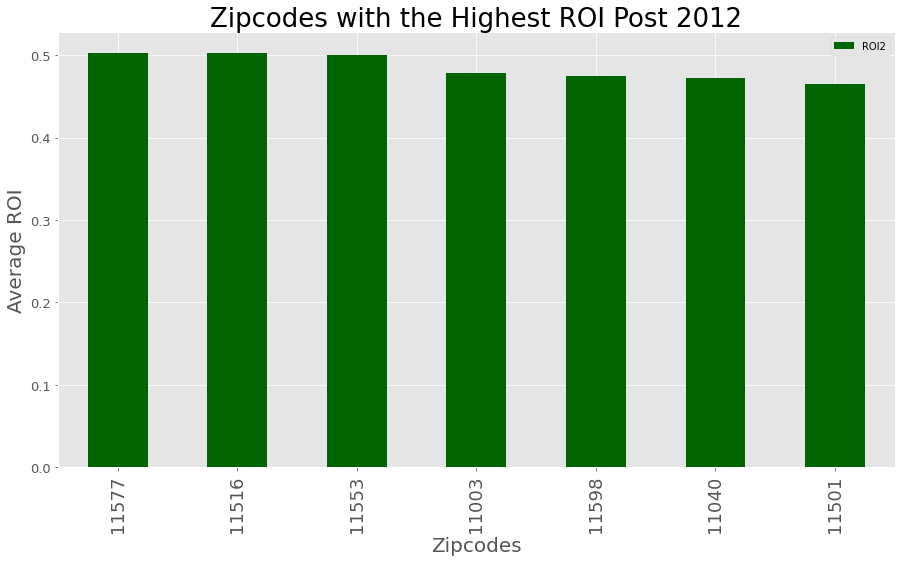

In [54]:
ax4 =ROI2_topzip.plot(kind='bar', figsize=(15,8), color="darkgreen", fontsize=13);
ax4.set_alpha(0.8)

ax4.set_title("Zipcodes with the Highest ROI Post 2012", fontsize=26)
ax4.set_ylabel("Average ROI", fontsize=20);
ax4.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.show()

The zipcodes with the highest ROI's post 2012 are:
* 11577: Roslyn Heights, NY
* 11516: Cedarhurst, NY
* 11553: Uniondale, NY (X)
* 11003: Elmont, NY 
* 11598: Woodmere, NY
* 11040: New Hyde Park, NY
* 11501: Mineola, NY

# Time Series Basics

Time Series data is experimental data that has been observed at different points in time.

Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc.

## Forecasting with ARIMA

Forecasting is the process of making predictions of the future, based on past and present data. One of the most common methods for this is the ARIMA model, which stands for AutoRegressive Integrated Moving Average

ARIMA is a model that can be fitted totime series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
* d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series
* q is the parameter associated with the moving average part of the model.

If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.

## Seasonality

Simply, a time series consists of three components -Seasonality, Trend, and Residuals. Variation of these components will cause the change in patterns of the time series. If Seasonality is part of the time series then we will have to use a SARIMA model.

One of the most important features of a time series is variation. Variations are patterns in the times series data. A time series that has patterns that repeat over known and fixed periods of time is said to have seasonality.

The Data Needs to be detrended or made stationary before we use ARIMA models

Before we move on to our time series models, let's look at another method to remove trend and seasonality, namely Time Series Decomposition.

Time series decomposition is a mathematical procedure that transforms a time series into multiple different time series.

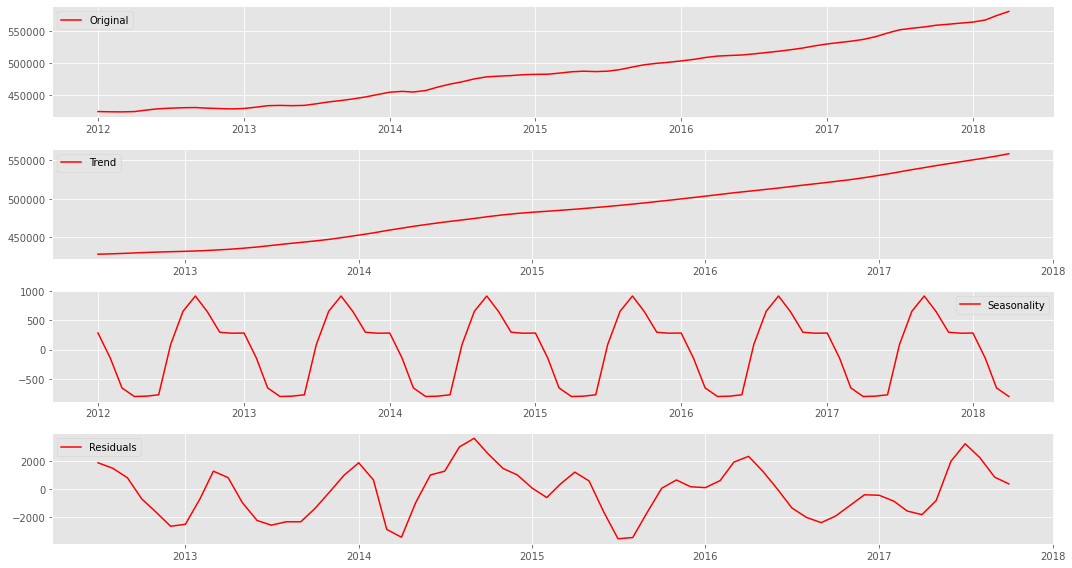

In [55]:
# Import seasonal_descompose()
decomposition = sm.tsa.seasonal_decompose(df12_month, model='additive')

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the Trend, Seasonality, and Residuals
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(df12_month, label='Original', color='red')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='red')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()

From the plot above we can clearly see the seasonal component of the data, and we can also see the separated upward trend of the data.

## Stationarity

Let's use the Dickey Fuller Test to confirm that the data is not stationary

Our next task is to use the code from previous labs to create a function stationarity_check() that takes in a time series and performs stationarity checks including rolling statistics and the Dickey-Fuller test.

We want the output of the function to:

* Plot the original time series along with the rolling mean and rolling standard deviation (use a window of 8) in one plot
* Output the results of the Dickey-Fuller test

The Dickey-Fuller test is a statistical test for testing stationarity. The null-hypothesis for the test is that the time series is not stationary.

So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary

In [56]:
# Lets check stationarity of residuals using our check_stationarity() function.
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(15,8))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [57]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

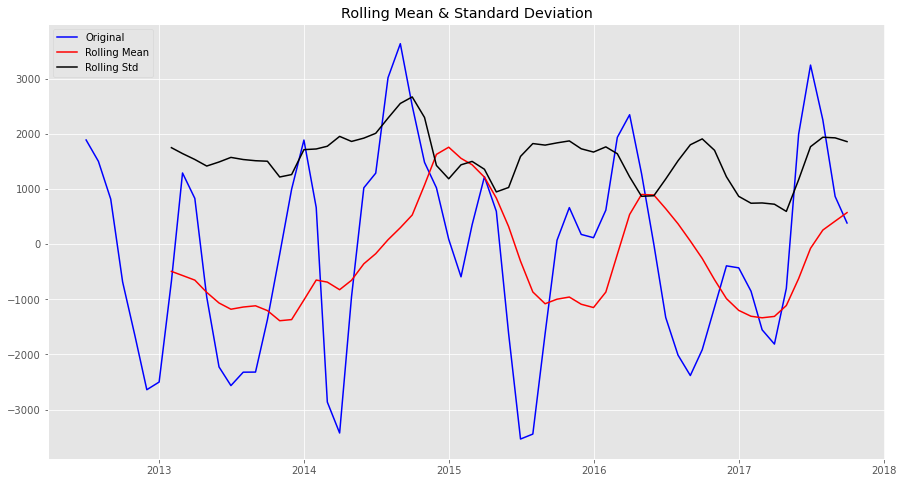

Results of Dickey-Fuller Test: 

Test Statistic                 -3.503839
p-value                         0.007889
#Lags Used                      9.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [58]:
# Use the newly created function on the ts timeseries.
stationarity_check(ts_log_decompose)

Time Series is not stationary:

* The mean is increasing and decreasing over time
* The test statistic is greater than the 1% Critical Value, hence we cannot reject the null hypothesis of the data is not stationary at the 99% level of significance.

## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

The ACF can answer some questions like:
* Is the observed time series white noise / random?- non zero correlations show relationship between the data points
* Is an observation related to an adjacent observation or other points within it?
* Can the observed time series be modeled with an MA model?

<AxesSubplot:xlabel='Date'>

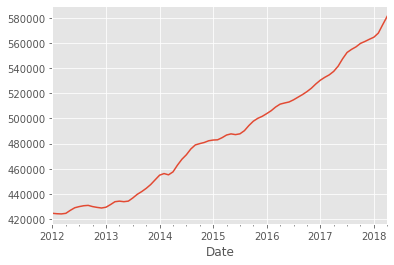

In [59]:
# Autocorrelation
df12_month.plot()

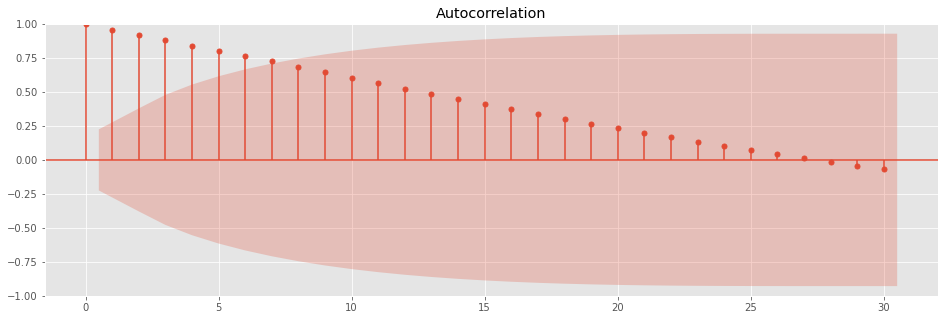

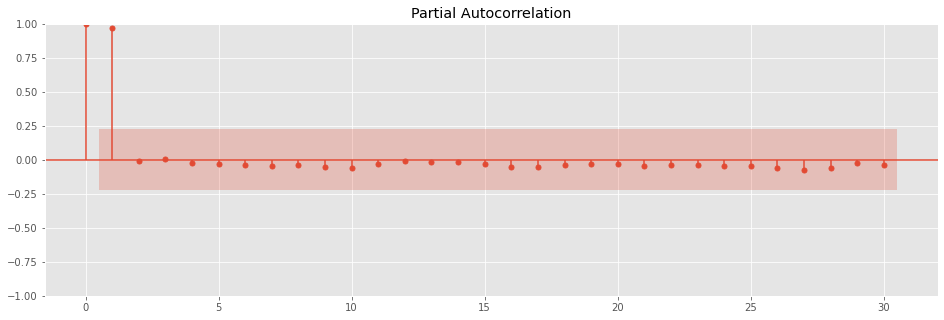

In [60]:
fig, ax = plt.subplots(figsize=(16,5))
plot_acf(df12_month, ax=ax, lags=30);

fig, ax = plt.subplots(figsize=(16,5))
plot_pacf(df12_month, ax=ax, lags=30);

There is autocorrelation in the time series at several lags. Therefore, the time series is non-random.There is also significant partial correlations which further continues to support that the series is not random

The series is heavily autocorrelated at first, and then there is a decay. This is a typical result for a series that is a random walk, generally you'll see heavy autocorrelations first, slowly tailing off until there is no autocorrelation anymore.

## Detrending by Differencing

Partial Autocorrelation Function gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags.

<AxesSubplot:xlabel='Date'>

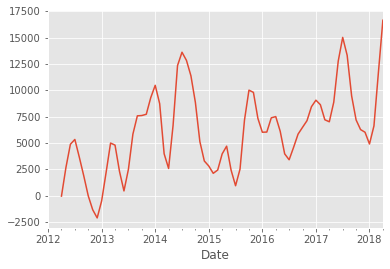

In [61]:
# If we take lag = 3 difference. Autocorrlation appears.
df12_month.diff(periods=3).plot()

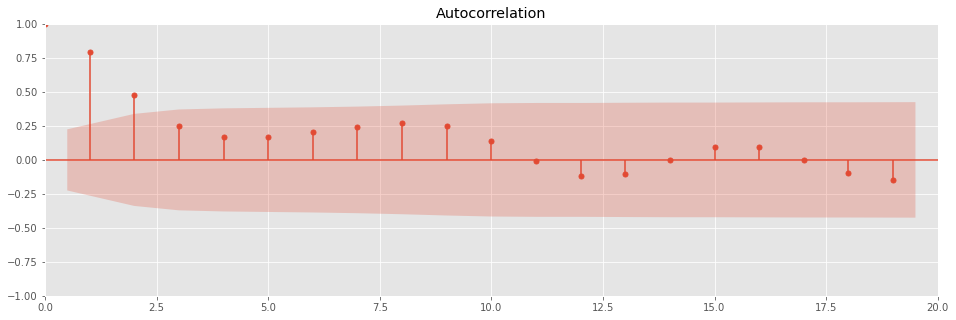

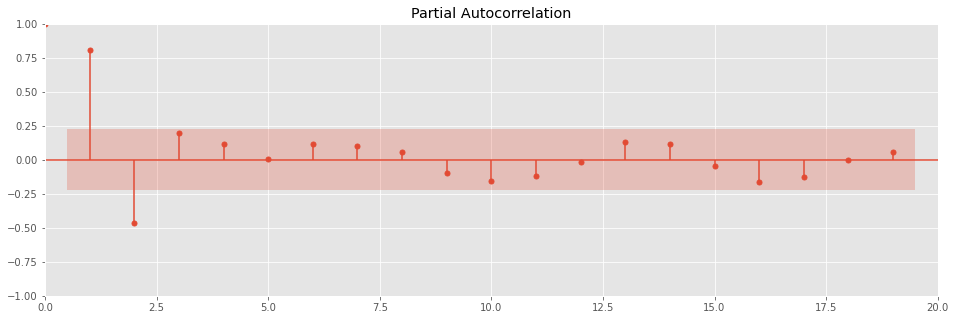

In [62]:
# Autocorrelation and Partial Autocorrelation Graphs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=16,5
plot_acf(df12_month.diff(periods=3).bfill()); plt.xlim(0,20); plt.show()
plot_pacf(df12_month.diff(periods=3).bfill()); plt.xlim(0,20); plt.ylim(-1,1);
plt.show()

We are ready to start our ARIMA time series modeling

# (S)ARIMA Model

We want to build a Time Series model to predict the future ROI for each zip code in Nassau County that would fit our client's budget. But first, we will select 5 specific zipcode to build our time series model on. For this purpose, we decided to use the highest growing zipcode since 2012.

## [Initial Model] using 5 Sample Zipcodes

In [63]:
lidf_melt2 = lidf_melt['2012':]

In [64]:
lidf_melt2.Zipcode.unique()

<StringArray>
['11758', '11561', '11550', '11520', '11590', '11040', '11756', '11554',
 '11801', '11580', '11566', '11050', '11710', '11735', '11510', '11793',
 '11003', '11572', '11570', '11530', '11803', '11001', '11791', '11501',
 '11563', '11714', '11010', '11552', '11762', '11783', '11581', '11553',
 '11753', '11577', '11598', '11575', '11545', '11518', '11771', '11596',
 '11565', '11557', '11558', '11516', '11709', '11560', '11507', '11096',
 '11579', '11804', '11514', '11732', '11509', '11569']
Length: 54, dtype: string

In [65]:
#Select Top 5 (ROI) zipcodes
zip_dfs = []
zip_list = np.array(['11577','11516','11003','11598','11040'])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(lidf_melt2[lidf_melt2['Zipcode']==x][['MeanValue']].copy()))

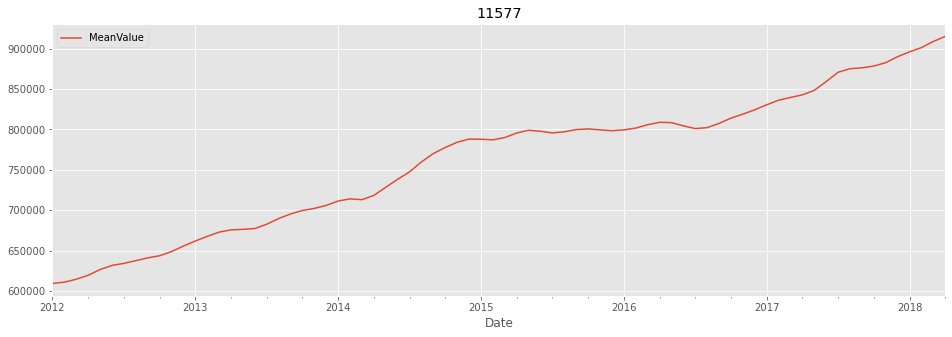

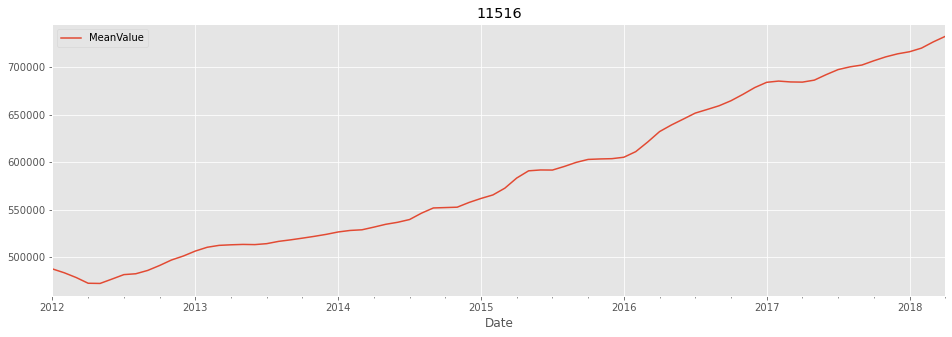

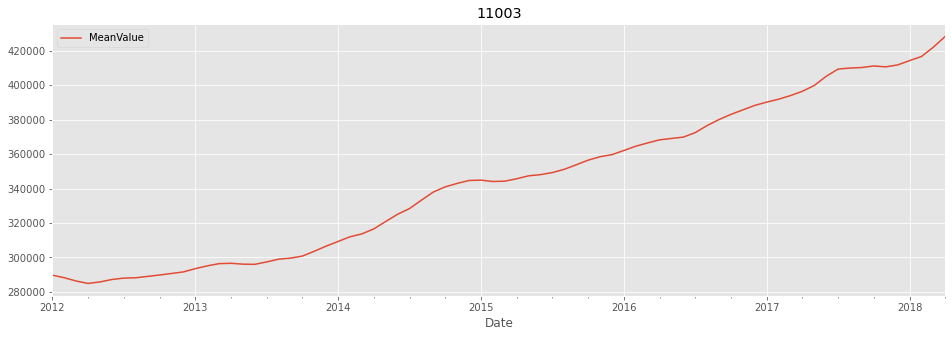

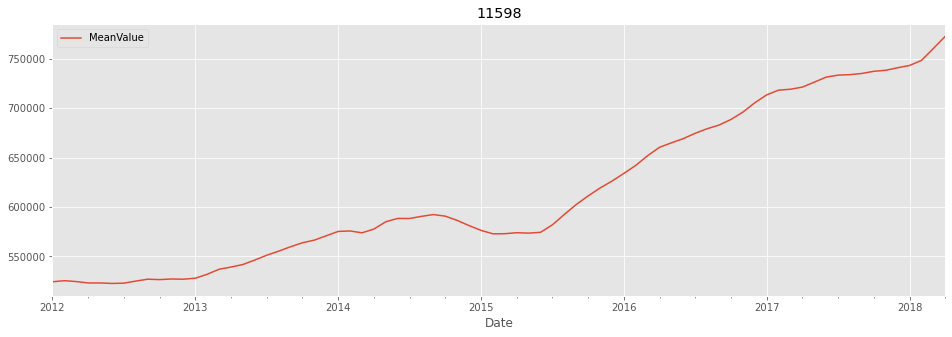

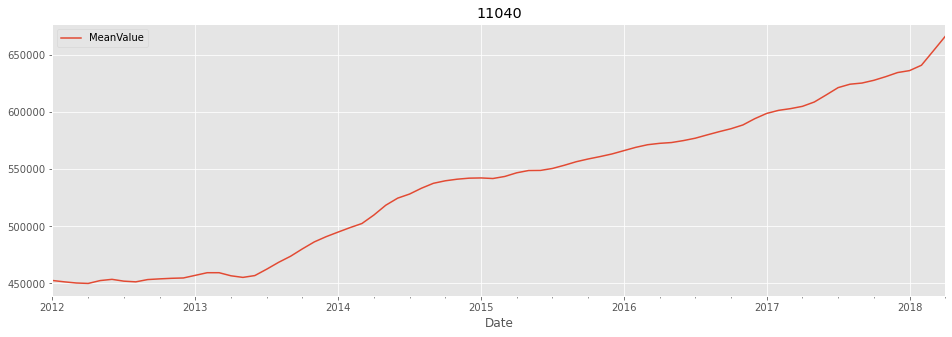

In [66]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

### Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

In [67]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [68]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [69]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 11577 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2247.7235739869047
Result for 11577 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1855.5620160312894
Result for 11577 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1551.4824765234262
Result for 11577 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1255.5397948929904
Result for 11577 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1480.224258957166
Result for 11577 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1456.8007050095716
Result for 11577 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1245.4851061765362
Result for 11577 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1268.0981042858973
Result for 11577 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 2167.402557587817
Result for 11577 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1929.285371411138
Result for 11577 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1562.0067093345879
Result for 11577 ARIMA (

Result for 11516 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 960.722628273569
Result for 11516 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 923.347524060459
Result for 11516 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1416.7169928527799
Result for 11516 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1178.8349737743265
Result for 11516 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1234.5856119971934
Result for 11516 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1079.8218923639
Result for 11516 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1178.8910980261705
Result for 11516 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1261.8301074040337
Result for 11516 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 991.9760370772938
Result for 11516 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 993.1010101584934
Result for 11516 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1343.005645082754
Result for 11516 ARIMA (1, 0, 1

Result for 11003 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 857.5818302836989
Result for 11003 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1039.3737707075368
Result for 11003 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1023.1595749891933
Result for 11003 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 868.2026919658902
Result for 11003 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 869.063580105617
Result for 11598 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2215.893766385711
Result for 11598 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3312540.0041162306
Result for 11598 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1545.3381080106437
Result for 11598 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1262.221730475565
Result for 11598 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1494.2186592246953
Result for 11598 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1472.4663778896265
Result for 11598 ARIMA (0, 

Result for 11040 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1170.5884153993707
Result for 11040 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 921.5975304230137
Result for 11040 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1175.8005396940905
Result for 11040 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1138.6021976508807
Result for 11040 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 954.3730804855126
Result for 11040 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 916.5563349974742
Result for 11040 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1398.9475588635103
Result for 11040 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1689.9267694143732
Result for 11040 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1227.4753486165696
Result for 11040 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 994.9268384267534
Result for 11040 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1261.767182589444
Result for 11040 ARIMA (1,

In [70]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies

* 1. the goodness of fit
* 2. the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [71]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [72]:
best_para

,name,pdq,pdqs,AIC
187,11003,"(1, 1, 1)","(0, 1, 1, 12)",857.581830
315,11040,"(1, 1, 1)","(0, 1, 1, 12)",897.992133
127,11516,"(1, 1, 1)","(1, 1, 1, 12)",910.417843
59,11577,"(1, 1, 1)","(0, 1, 1, 12)",930.593575
251,11598,"(1, 1, 1)","(0, 1, 1, 12)",937.414508


In [73]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])                         
                           
# Fit the model and print results

SARIMA Model Result for 11003
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6358      0.102      6.260      0.000       0.437       0.835
ma.L1          0.7143      0.102      7.034      0.000       0.515       0.913
ma.S.L12       0.0523      0.031      1.709      0.088      -0.008       0.112
sigma2      8.019e+06   2.48e-09   3.24e+15      0.000    8.02e+06    8.02e+06
SARIMA Model Result for 11040
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5164      0.153      3.383      0.001       0.217       0.816
ma.L1          0.7296      0.100      7.309      0.000       0.534       0.925
ma.S.L12       0.0507      0.047      1.088      0.276      -0.041       0.142
sigma2      5.816e+06   2.07e-09   2.81e+15      0.000    5.82e+06    5

### Dynamic Forecast using Training Data with Test Data 

The train-test split for a time series is a little different from what we are used to. Because chronological order matters, we cannot randomly sample points in our data. Instead, we cut off a portion of our data at the end, and reserve it as our test set.

We can then fit the stepwise_model object to a training data set. Because this is a time series forecast, we will “chop off” a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off.

We’ll train on the first 6 years of data, from the years 2012–2016 and test our forecast on the years after that and compare it to the real data:

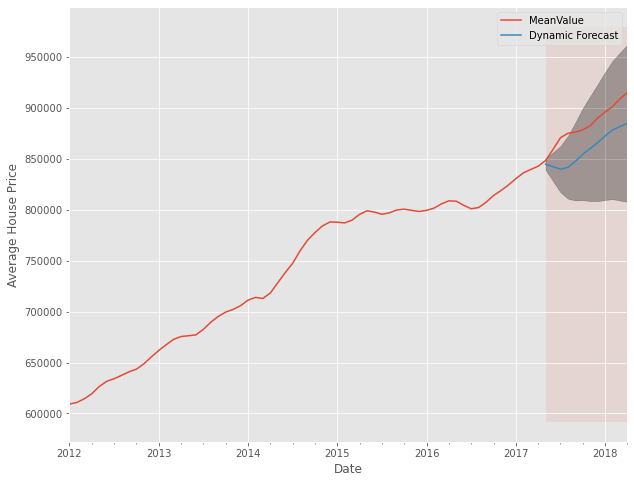

The Mean Squared Error of our forecasts is 25185.9


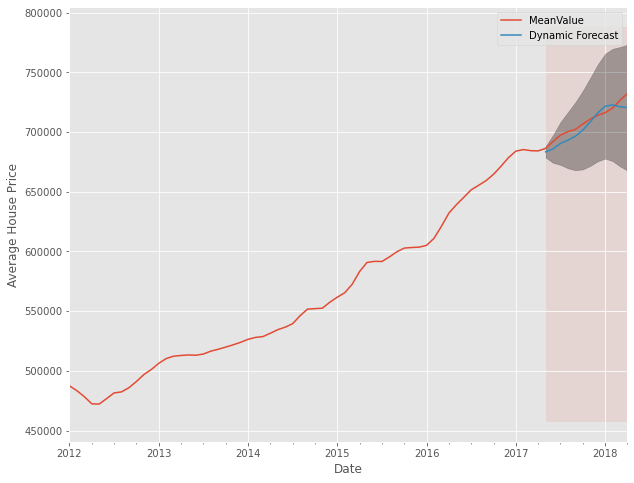

The Mean Squared Error of our forecasts is 5941.84


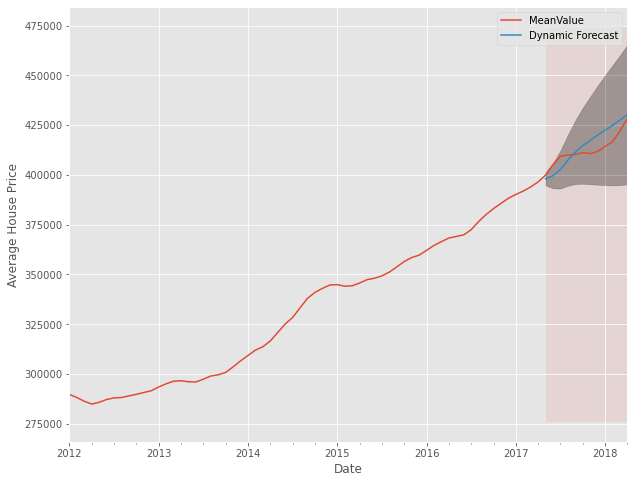

The Mean Squared Error of our forecasts is 5621.4


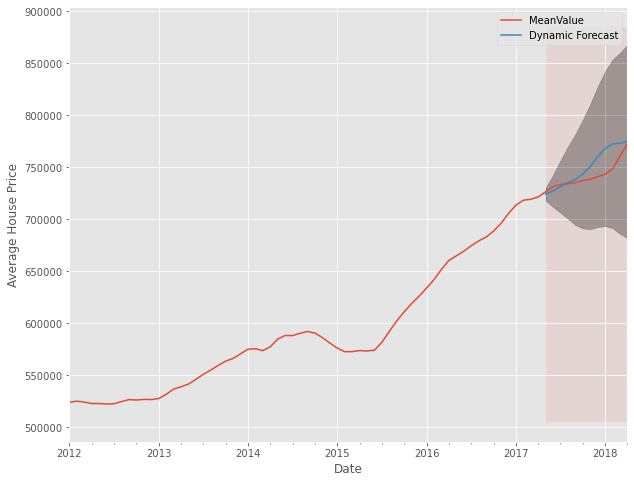

The Mean Squared Error of our forecasts is 12685.45


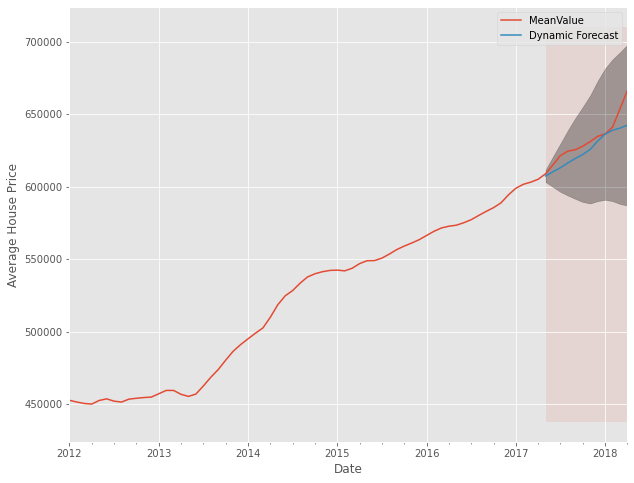

The Mean Squared Error of our forecasts is 9241.49


In [74]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-05-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-05-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2012':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='black', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-05-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value

In [75]:
summary_table

,Zipcode,Sqrt_MSE
0,11003,25185.904262
1,11040,5941.841812
2,11516,5621.400797
3,11577,12685.448863
4,11598,9241.493988


### Visualizing Forecasts

In [76]:
forecast_table = pd.DataFrame()
current = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [77]:
forecast_table

,Zipcode,Current Value,5 Years Value,5Yr-ROI
0,11003,915400.0,1.291861e+06,0.411253
1,11040,732400.0,1.011766e+06,0.381439
2,11516,428400.0,6.438231e+05,0.502855
3,11577,772900.0,1.114313e+06,0.441729
4,11598,666400.0,1.068893e+06,0.603981


## [Final Model] SARIMA on all Zipcodes

In [78]:
zip_dfs = []
zip_list = lidf_melt2.Zipcode.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(lidf_melt2[lidf_melt2['Zipcode']==x][['MeanValue']].copy()))

In [79]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [80]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 11758 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2155.567009163548
Result for 11758 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1672645.309840534
Result for 11758 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1434.1495933888557
Result for 11758 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1171.9373260614032
Result for 11758 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1338.6306551265186
Result for 11758 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1277.6884861584085
Result for 11758 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1131.7004471332325
Result for 11758 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1093.15394395545
Result for 11758 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 2076.288565580845
Result for 11758 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1717654.4366045021
Result for 11758 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1439.2011664785616
Result for 11758 ARIMA (0,

Result for 11561 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1129.053672644096
Result for 11561 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 966.9613596831056
Result for 11561 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 924.7362870363313
Result for 11561 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1446.385941206621
Result for 11561 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1675.0354120387917
Result for 11561 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1249.2446212650732
Result for 11561 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1015.2500430806521
Result for 11561 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1222.80167497451
Result for 11561 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1319.157184907095
Result for 11561 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1011.0299632248169
Result for 11561 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1443.460728498413
Result for 11561 ARIMA (1, 0,

Result for 11550 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1122.352785853967
Result for 11550 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 850.7147055301771
Result for 11550 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1032.563413900637
Result for 11550 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1017.9668449620933
Result for 11550 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 869.7942161936526
Result for 11550 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 850.5508364499335
Result for 11520 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2104.1517083794874
Result for 11520 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1735.3784500282031
Result for 11520 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1446.8910561276984
Result for 11520 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1182.850415638983
Result for 11520 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1416.790750046914
Result for 11520 ARIMA (0, 0

Result for 11590 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 912.1217392306249
Result for 11590 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1272.8874856207992
Result for 11590 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1064.616226412091
Result for 11590 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1115.878842909047
Result for 11590 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 877.1974444787588
Result for 11590 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1110.2840831435958
Result for 11590 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1073.1170166290196
Result for 11590 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 914.2027282482384
Result for 11590 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 865.3751811847724
Result for 11590 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1314.7070305851473
Result for 11590 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1104.8539219357851
Result for 11590 ARIMA (1, 

Result for 11040 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 920.6342572510115
Result for 11040 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 924.6519442835248
Result for 11040 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1308.1081664263459
Result for 11040 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1078.9353765517283
Result for 11040 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1137.1744821796558
Result for 11040 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 897.9921331583282
Result for 11040 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1099.4981418920806
Result for 11040 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1080.1727043009728
Result for 11040 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 921.9903234820816
Result for 11040 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 899.3966133622755
Result for 11756 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2128.5346947930925
Result for 11756 ARIMA (0,

Result for 11554 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1162.8767644152274
Result for 11554 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1143.6248680571957
Result for 11554 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 918.2983159075652
Result for 11554 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 901.0320048140679
Result for 11554 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1275.7550690946741
Result for 11554 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1069.3432021635626
Result for 11554 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1112.783461381945
Result for 11554 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 871.1706744073891
Result for 11554 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1111.3108961883006
Result for 11554 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1082.1825631072234
Result for 11554 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 906.7098825557558
Result for 11554 ARIMA (0,

Result for 11801 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 882.939692735237
Result for 11801 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1050.07271978546
Result for 11801 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1055.648977789431
Result for 11801 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 870.1902978228775
Result for 11801 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 872.079192416865
Result for 11801 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1235.1239907471218
Result for 11801 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1017.4199185162435
Result for 11801 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1075.8742829262135
Result for 11801 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 849.7601421403489
Result for 11801 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1036.0067578799933
Result for 11801 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1019.0748223272607
Result for 11801 ARIMA (1, 1, 

Result for 11566 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1133.8145445924597
Result for 11566 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 907.2220545616972
Result for 11566 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 892.0094629068765
Result for 11566 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1270.9235233665077
Result for 11566 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1058.9125727700375
Result for 11566 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1106.4774354064443
Result for 11566 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 859.3715206896962
Result for 11566 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1111.6122132292085
Result for 11566 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1060.8015147418532
Result for 11566 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 902.9852510554537
Result for 11566 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 855.1633640605517
Result for 11566 ARIMA (1,

Result for 11050 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 976.3023992577247
Result for 11050 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1151.7183073347824
Result for 11050 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1151.3447301684594
Result for 11050 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 953.5027312394984
Result for 11050 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 955.4167692729773
Result for 11050 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1355.7700958301514
Result for 11050 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1109.2906345869958
Result for 11050 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1197.7001297281502
Result for 11050 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 934.1397047305384
Result for 11050 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1156.5137406621986
Result for 11050 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1111.0656574869333
Result for 11050 ARIMA (1

Result for 11735 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 902.0010105417214
Result for 11735 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1139.392700400917
Result for 11735 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1119.2917223282323
Result for 11735 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 914.0346998078275
Result for 11735 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 899.893261325934
Result for 11735 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1257.6692174041218
Result for 11735 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1047.6959604395076
Result for 11735 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1096.984524184002
Result for 11735 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 846.8986124951577
Result for 11735 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1094.8461033863143
Result for 11735 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1048.6554621746245
Result for 11735 ARIMA (0, 1

Result for 11510 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 875.3909930609285
Result for 11510 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1038.3353523081644
Result for 11510 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1039.7655470861944
Result for 11510 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 864.7085741863847
Result for 11510 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 866.6916411032478
Result for 11510 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1219.1428935198878
Result for 11510 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1002.8096988141591
Result for 11510 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1065.580290270413
Result for 11510 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 839.5613630602119
Result for 11510 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1018.3999667484743
Result for 11510 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1004.4949529741526
Result for 11510 ARIMA (1,

Result for 11003 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 921.4559481280899
Result for 11003 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1147.5694661077682
Result for 11003 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1146.4124722282222
Result for 11003 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 927.344533000779
Result for 11003 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 925.9249137019134
Result for 11003 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1273.5688785743955
Result for 11003 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1063.6630045229317
Result for 11003 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1098.7382192050793
Result for 11003 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 905.619369937847
Result for 11003 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1106.1018847278551
Result for 11003 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1065.5875431746458
Result for 11003 ARIMA (0, 

Result for 11572 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 886.9637351447727
Result for 11572 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1052.939187781536
Result for 11572 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1056.23655189608
Result for 11572 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 875.9438408499835
Result for 11572 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 879.6064417775533
Result for 11572 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1234.869397758157
Result for 11572 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1019.0196737378207
Result for 11572 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1079.5713705293158
Result for 11572 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 853.6336291359319
Result for 11572 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1034.8062526559513
Result for 11572 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1020.8150008849827
Result for 11572 ARIMA (1, 1,

Result for 11530 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 995.9790471160477
Result for 11530 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1234.302724426748
Result for 11530 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1222.3939238136588
Result for 11530 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 987.9030362495885
Result for 11530 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 971.837262053735
Result for 11530 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1364.2611206809493
Result for 11530 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1135.253697968681
Result for 11530 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1195.7986051680525
Result for 11530 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 941.5696994590052
Result for 11530 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1184.679179361792
Result for 11530 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1147.2104813144322
Result for 11530 ARIMA (0, 1,

Result for 11803 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 913.7649950616376
Result for 11803 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1092.6447282498411
Result for 11803 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1090.9204704131816
Result for 11803 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 900.7409284889925
Result for 11803 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 903.2564639669861
Result for 11803 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1274.0308591461512
Result for 11803 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1042.9433771022032
Result for 11803 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1141.0801946759218
Result for 11803 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 872.8685260150087
Result for 11803 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1059.3418737770264
Result for 11803 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1044.8229893986368
Result for 11803 ARIMA (1

Result for 11791 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1201.425826241353
Result for 11791 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1181.5300864857757
Result for 11791 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 956.2377731511622
Result for 11791 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 940.4483436574883
Result for 11791 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1338.4774927679475
Result for 11791 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1104.3888101333162
Result for 11791 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1157.7759447025264
Result for 11791 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 898.1174114974831
Result for 11791 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1160.0459174160148
Result for 11791 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1120.747418636986
Result for 11791 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 937.0952785282525
Result for 11791 ARIMA (0, 

Result for 11501 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 924.6910758978928
Result for 11501 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1083.1014878218273
Result for 11501 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1085.6403153421354
Result for 11501 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 905.6969137762611
Result for 11501 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 912.2785783203742
Result for 11501 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1276.3540606523252
Result for 11501 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1053.6348348188358
Result for 11501 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1127.2692225451838
Result for 11501 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 888.535879784164
Result for 11501 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1084.8362592615356
Result for 11501 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1055.6076697298297
Result for 11501 ARIMA (1,

Result for 11714 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 943.0772987690125
Result for 11714 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1168.3558825727716
Result for 11714 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1157.1714522259447
Result for 11714 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 951.4451141641649
Result for 11714 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 943.8792533941661
Result for 11714 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1284.0593599849865
Result for 11714 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1070.569496365209
Result for 11714 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1129.31489545815
Result for 11714 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 891.6574394548319
Result for 11714 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1107.8688124193936
Result for 11714 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1078.967849288284
Result for 11714 ARIMA (0, 1,

Result for 11010 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 911.5594116128552
Result for 11010 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1080.9086651421044
Result for 11010 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1088.9828885590036
Result for 11010 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 894.4909616985625
Result for 11010 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 899.4287643966236
Result for 11010 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1269.9011302971112
Result for 11010 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1042.1139947467689
Result for 11010 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1143.8797435724366
Result for 11010 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 874.3216775883601
Result for 11010 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1058.3747102777738
Result for 11010 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1043.9820279904918
Result for 11010 ARIMA (1

Result for 11762 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1159.206839299581
Result for 11762 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1142.041020110056
Result for 11762 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 926.9283999585932
Result for 11762 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 912.6882901796417
Result for 11762 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1273.048550089856
Result for 11762 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1064.9976538656456
Result for 11762 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1122.5307426840523
Result for 11762 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 881.5231338460326
Result for 11762 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1103.187067797466
Result for 11762 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1066.7766428017158
Result for 11762 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 911.9905931286137
Result for 11762 ARIMA (0, 1,

Result for 11783 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 894.6567518386171
Result for 11783 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1050.9384615146366
Result for 11783 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1051.8489345246126
Result for 11783 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 880.8264750685112
Result for 11783 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 882.8088601676884
Result for 11783 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1239.8118870313597
Result for 11783 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1018.2942948604718
Result for 11783 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1097.235756183806
Result for 11783 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 854.7247007764405
Result for 11783 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1057.5176643998723
Result for 11783 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1019.480931105494
Result for 11783 ARIMA (1, 

Result for 11553 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 916.7570225702109
Result for 11553 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1145.2909940582692
Result for 11553 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1136.0062724418867
Result for 11553 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 932.9514693007104
Result for 11553 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 916.9846834371403
Result for 11553 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1266.49127830827
Result for 11553 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1053.1635479541233
Result for 11553 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1098.2955451983225
Result for 11553 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 935.2932725271679
Result for 11553 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1108.4731623420255
Result for 11553 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1054.9222259009878
Result for 11553 ARIMA (0, 

Result for 11753 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 943.281095498073
Result for 11753 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1121.1890522164197
Result for 11753 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1121.513738909465
Result for 11753 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 931.5417560173063
Result for 11753 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 933.7095068411088
Result for 11753 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1313.4920928626273
Result for 11753 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1091.7257752272958
Result for 11753 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1146.3653178294012
Result for 11753 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 912.1799120747025
Result for 11753 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1108.3940394634171
Result for 11753 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1093.6060007776334
Result for 11753 ARIMA (1, 

Result for 11598 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1261.5011804061867
Result for 11598 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1246.5389974817585
Result for 11598 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1024.701648423431
Result for 11598 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1006.9562521102881
Result for 11598 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1380.0514644453187
Result for 11598 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1170.6223846514897
Result for 11598 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1260.460901720425
Result for 11598 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 967.8444388963879
Result for 11598 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1209.6830131959389
Result for 11598 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1172.4948927044081
Result for 11598 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 1006.0842859260744
Result for 11598 ARIMA (

Result for 11575 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 915.7664578721033
Result for 11575 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1082.4463891752355
Result for 11575 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1084.4782596761634
Result for 11575 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 897.1631725910686
Result for 11575 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 908.7301905558763
Result for 11575 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1277.0350985197056
Result for 11575 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1037.2550436301892
Result for 11575 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1124.4313736120826
Result for 11575 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 874.5723344742538
Result for 11575 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1055.2404036046166
Result for 11575 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1039.155574862159
Result for 11575 ARIMA (1,

Result for 11518 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1172.5048879439653
Result for 11518 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1154.489455176669
Result for 11518 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 950.4332885448151
Result for 11518 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 933.3347599162645
Result for 11518 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1280.0835179487146
Result for 11518 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1077.572695673825
Result for 11518 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1124.712609558075
Result for 11518 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 886.1441273897112
Result for 11518 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1120.6747376843168
Result for 11518 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1084.9832118210868
Result for 11518 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 917.4867104534139
Result for 11518 ARIMA (0, 1

Result for 11771 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 988.4212403790677
Result for 11771 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1174.9688347966985
Result for 11771 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1176.5989052342343
Result for 11771 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 967.2859117660025
Result for 11771 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 965.267304795183
Result for 11771 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1371.4519801394467
Result for 11771 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1136.7524721144237
Result for 11771 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1198.0500494382277
Result for 11771 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 956.620315153765
Result for 11771 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1155.543553611401
Result for 11771 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1138.349790336914
Result for 11771 ARIMA (1, 1,

Result for 11565 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1152.3196751506432
Result for 11565 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 928.0980207218065
Result for 11565 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 913.3361319105118
Result for 11565 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1283.1909828549524
Result for 11565 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1074.4482299411338
Result for 11565 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1128.044959684134
Result for 11565 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 872.4541624126002
Result for 11565 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1119.9116694360637
Result for 11565 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1075.868129863368
Result for 11565 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 902.9270887132774
Result for 11565 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 864.5931840552613
Result for 11565 ARIMA (1, 0

Result for 11557 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 949.0984525795058
Result for 11557 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1116.818343142019
Result for 11557 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1115.7616951761286
Result for 11557 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 918.0286212801464
Result for 11557 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 928.4726829770525
Result for 11557 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1312.6571301578535
Result for 11557 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1084.2919713292736
Result for 11557 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1156.003763143136
Result for 11557 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 917.795396215749
Result for 11557 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1119.3043818692909
Result for 11557 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1086.2533800324745
Result for 11557 ARIMA (1, 1

Result for 11516 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1200.859937022536
Result for 11516 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 989.6807092312492
Result for 11516 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 974.0912444040254
Result for 11516 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1370.5440590259554
Result for 11516 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1141.8991127329557
Result for 11516 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1177.6728077025646
Result for 11516 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 926.0265569685827
Result for 11516 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1185.3804943091218
Result for 11516 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1143.8662729462799
Result for 11516 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 960.722628273569
Result for 11516 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 923.347524060459
Result for 11516 ARIMA (1, 0,

Result for 11709 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 967.3285592916674
Result for 11709 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1136.8286515981601
Result for 11709 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1138.494925081272
Result for 11709 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 950.1292981593534
Result for 11709 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 956.4673663680703
Result for 11709 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1339.6762101854792
Result for 11709 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1091.7709524536099
Result for 11709 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1191.830707423928
Result for 11709 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 928.4311834861219
Result for 11709 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1109.9289674409233
Result for 11709 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1093.5443254955649
Result for 11709 ARIMA (1, 

Result for 11507 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1003.1291502276787
Result for 11507 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1237.3629941150252
Result for 11507 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1218.890232248758
Result for 11507 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 994.4482060765386
Result for 11507 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 978.7546451420815
Result for 11507 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1365.1274985391515
Result for 11507 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1141.8368610177877
Result for 11507 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1204.587669117922
Result for 11507 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 951.0708313400776
Result for 11507 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1184.4303342091773
Result for 11507 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1149.6304456245423
Result for 11507 ARIMA (0,

Result for 11096 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 980.9661121904162
Result for 11096 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1148.0708065417334
Result for 11096 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1150.0576739917308
Result for 11096 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 953.4212264441708
Result for 11096 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 965.2971461170641
Result for 11096 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1357.5798883852692
Result for 11096 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1109.3776493381818
Result for 11096 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1226.9695895720151
Result for 11096 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 949.511626273296
Result for 11096 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1132.4593466638607
Result for 11096 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1110.878085921391
Result for 11096 ARIMA (1, 

Result for 11804 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1223.8415908204668
Result for 11804 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1010.6201778510733
Result for 11804 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 993.4105927456615
Result for 11804 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1369.450257325282
Result for 11804 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1146.0938335572057
Result for 11804 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1278.9864122693816
Result for 11804 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 978.4534663700973
Result for 11804 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1184.212737668221
Result for 11804 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1147.998280898389
Result for 11804 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 1016.0254262053315
Result for 11804 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 978.08501723621
Result for 11804 ARIMA (1, 0,

Result for 11514 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 952.9901165010433
Result for 11514 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1112.9896804492598
Result for 11514 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1114.528017995578
Result for 11514 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 931.7055680989481
Result for 11514 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 937.1649394441582
Result for 11514 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1310.011103772365
Result for 11514 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1077.8009833161223
Result for 11514 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1153.9732139485172
Result for 11514 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 913.2962132629226
Result for 11514 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1095.541718539565
Result for 11514 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1078.0195431903167
Result for 11514 ARIMA (1, 1

Result for 11509 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1287.5991723605568
Result for 11509 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1085.5721107320712
Result for 11509 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1069.77800698125
Result for 11509 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1456.8611056653085
Result for 11509 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1212.6166066850226
Result for 11509 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1340.8578866003543
Result for 11509 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1033.3647411296165
Result for 11509 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1252.7868670782946
Result for 11509 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1213.4482125617
Result for 11509 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 1073.3569335581071
Result for 11509 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 1034.1454155594004
Result for 11509 ARIMA (1,

Result for 11569 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1062.2998080911686
Result for 11569 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1267.535321366042
Result for 11569 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1269.5271557326666
Result for 11569 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1047.8113668234537
Result for 11569 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1049.0533320690254
Result for 11569 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1470.2139536883444
Result for 11569 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1225.7919708010245
Result for 11569 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1322.1870014237697
Result for 11569 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1029.4809844094832
Result for 11569 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1246.438311054478
Result for 11569 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1226.1106838060773
Result for 11569 ARIMA 

In [81]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [82]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [83]:
best_para.head()

,name,pdq,pdqs,AIC
1407,11001,"(1, 1, 1)","(1, 1, 1, 12)",905.883943
1083,11003,"(1, 1, 1)","(0, 1, 1, 12)",857.581830
1727,11010,"(1, 1, 1)","(1, 1, 1, 12)",872.077626
379,11040,"(1, 1, 1)","(0, 1, 1, 12)",897.992133
767,11050,"(1, 1, 1)","(1, 1, 1, 12)",933.271413


In [84]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])                          
# Fit the model and print results

SARIMA Model Result for 11001
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4636      0.152      3.040      0.002       0.165       0.762
ma.L1          0.7010      0.120      5.822      0.000       0.465       0.937
ar.S.L12       0.0608      0.035      1.752      0.080      -0.007       0.129
ma.S.L12      -0.1499      0.086     -1.734      0.083      -0.319       0.020
sigma2      1.647e+06   9.34e-09   1.76e+14      0.000    1.65e+06    1.65e+06
SARIMA Model Result for 11003
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6700      0.118      5.675      0.000       0.439       0.901
ma.L1          0.7356      0.106      6.921      0.000       0.527       0.944
ma.S.L12       0.0269      0.041      0.659      0.510      -0.053     

SARIMA Model Result for 11518
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4328      0.205      2.115      0.034       0.032       0.834
ma.L1          1.2204      0.113     10.802      0.000       0.999       1.442
ar.S.L12       0.0475      0.039      1.214      0.225      -0.029       0.124
ma.S.L12      -0.0680      0.134     -0.506      0.613      -0.331       0.195
sigma2      1.673e+06   3.92e-08   4.26e+13      0.000    1.67e+06    1.67e+06
SARIMA Model Result for 11520
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5569      0.132      4.229      0.000       0.299       0.815
ma.L1          1.5737      0.356      4.417      0.000       0.875       2.272
ma.S.L12      -0.0017      0.036     -0.047      0.962      -0.073     

SARIMA Model Result for 11563
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5585      0.188      2.967      0.003       0.190       0.928
ma.L1          0.7572      0.147      5.148      0.000       0.469       1.046
ar.S.L12       0.0550      0.038      1.451      0.147      -0.019       0.129
ma.S.L12      -0.1150      0.105     -1.093      0.274      -0.321       0.091
sigma2      2.111e+06   1.07e-08   1.98e+14      0.000    2.11e+06    2.11e+06
SARIMA Model Result for 11565
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7396      0.121      6.107      0.000       0.502       0.977
ma.L1          0.6249      0.135      4.619      0.000       0.360       0.890
ar.S.L12       0.0835      0.048      1.728      0.084      -0.011     

SARIMA Model Result for 11596
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7092      0.104      6.805      0.000       0.505       0.913
ma.L1          0.1587      0.069      2.284      0.022       0.023       0.295
ar.S.L12      -0.3390      0.131     -2.579      0.010      -0.597      -0.081
ma.S.L12       0.0160      0.017      0.951      0.342      -0.017       0.049
sigma2      1.524e+07   1.63e-09   9.36e+15      0.000    1.52e+07    1.52e+07
SARIMA Model Result for 11598
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5502      0.187      2.950      0.003       0.185       0.916
ma.L1          1.3533      0.166      8.138      0.000       1.027       1.679
ma.S.L12       0.0502      0.054      0.933      0.351      -0.055     

SARIMA Model Result for 11783
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7122      0.089      7.963      0.000       0.537       0.888
ma.L1          0.1450      0.039      3.679      0.000       0.068       0.222
ar.S.L12      -0.5129      0.124     -4.126      0.000      -0.757      -0.269
ma.S.L12       0.0098      0.029      0.341      0.733      -0.047       0.066
sigma2       9.18e+06   2.41e-09   3.81e+15      0.000    9.18e+06    9.18e+06
SARIMA Model Result for 11791
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7016      0.250      2.811      0.005       0.212       1.191
ma.L1          0.1286      0.073      1.769      0.077      -0.014       0.271
ar.S.L12      -0.6331      0.233     -2.722      0.006      -1.089     

### Dynamic forecast on 2017-06-01 onwards and compare with real values

In [85]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-05-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-05-01':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value

In [86]:
#Get the MSE
summary_table.head()

,Zipcode,Sqrt_MSE
0,11001,9397.465457
1,11003,8752.308267
2,11010,7847.341175
3,11040,6650.072868
4,11050,5805.158190


In [87]:
# Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_5Yr =[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

,Zipcode,Current Value,5 Years Value,5 Years Lower,5 Years Upper,5Yr-ROI,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11001,485900.0,648367.579073,462373.467537,8.343617e+05,0.334364,-0.048418,0.717147
1,11003,566900.0,910321.418533,376541.536295,1.444101e+06,0.605788,-0.335788,1.547365
2,11010,339100.0,518185.014537,276587.543264,7.597825e+05,0.528119,-0.184348,1.240585
3,11040,366700.0,530024.230169,239921.801400,8.201267e+05,0.445389,-0.345727,1.236506
4,11050,466200.0,644503.547398,511426.497278,7.775806e+05,0.382461,0.097011,0.667912


### Top 5 Zip codes with Highest 5Yr-ROI

In [88]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,5 Years Value,5 Years Lower,5 Years Upper,5Yr-ROI,5Yr-ROI-Lower,5Yr-ROI-Upper
42,11735,467900.0,7.998891e+05,139954.372143,1.459824e+06,0.709530,-0.700888,2.119948
52,11803,880000.0,1.491852e+06,-428918.050511,3.412622e+06,0.695286,-1.487407,2.877979
37,11598,488500.0,7.862295e+05,432429.866933,1.140029e+06,0.609477,-0.114780,1.333734
1,11003,566900.0,9.103214e+05,376541.536295,1.444101e+06,0.605788,-0.335788,1.547365
17,11552,502500.0,7.985622e+05,520921.460051,1.076203e+06,0.589178,0.036660,1.141697


# Interpreting Results

Based on the 5 year ROI, below 5 zipcodes stand out to be the best to invest for real estate investors. 

* 11735: Farmingdale, NY  (-70% to 211%)
* 11803: Plainview, NY   (-148% to 287%)
* 11598: Woodmere, NY     (-11% to 133%)
* 11003: Elmont, NY       (-33% to 154%)
* 11552: West Hempstead, NY (3% to 114%)

The zipcodes with the highest price volatility are:
* 11575: Roosevelt, NY
* 11096: Inwood, NY
* 11561: Long Beach, NY
* 11550: Hempstead, NY
* 11553: Uniondale, NY

Meaning that real estate investors should not invest in these areas

The methods we will employ in this project example will only take in data from a uni-variate time series. That means we really are only considering the relationship between the y-axis value the x-axis time points. We’re not considering outside factors that may be effecting the time series.

# Old Work (Not Used in Project)

In [ ]:
# Dataframe containining historical prices of the 11516 Zip Code.
z11516 = lidf_melt[lidf_melt['Zipcode']=='11516']

In [ ]:
z11516

In [ ]:
z11516 = z11516.drop(['Zipcode'], axis = 'columns')

In [ ]:
z11516

We have taken a look at the price history of various zipcodes earlier. Let's now look at the overall average price history of our selected zip-code individually.

In [ ]:
# Visualizing our Time Series Data for zipcode- 11516
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(z11516)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 11516 Price History',fontsize=30);

In [ ]:
# Relevance of Recent Data
recent = z11516['2012':]

In [ ]:
#Visualizing our Time Series Data for zipcode- 11516 from 2012

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(recent)

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 11516- Price since 2012',fontsize=30);

In [ ]:
# Splitting the last year of our series as a test dataset.
train_series = recent[:'2017-04']
test_series = recent['2017-05':]

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
print(pdqs)

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_series,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-05'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

Now that we have received predictions for our training data, let us plot it against our test data.

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = recent.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='black', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

In [ ]:
pred.predicted_mean.head()

In [ ]:
recent.head()

In [ ]:
# Get the real and predicted values
recent_forecasted = pred.predicted_mean
recent_truth = recent['2017-04-01':]

# Compute the mean square error
mse = ((recent_forecasted - recent_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    

In [ ]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model that fits the entire series.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent, 
                                        order=(1,1,1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

In [ ]:
#Plotting our Forecast

fig, ax = plt.subplots()
recent.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightgreen',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 11516 - With Forcasted Value & Confidence Intervals')
plt.show()

In [ ]:
# Splitting the last 24 months of our series as a test dataset.
train_series = recent[:'2016-04']
test_series = recent['2016-05':]

In [ ]:
$ pip install pmdarima

In [ ]:
$ conda config --add channels conda-forge
$ conda config --set channel_priority strict
$ conda install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)

In [ ]:
# From Flatiron

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_series,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
result = pd.DataFrame(ans, columns = ['pdq','pdqs','AIC'])

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()